In [47]:
%pip install matplotlib
%pip install pandas
%pip install pint

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import pint

In [52]:
ureg = pint.UnitRegistry()

In [66]:
def make_line_better(json):
    if "cpu_atom" in json["event"]:
        return None
    if "instructions" in json["event"]:
        return ("instructions", float(json["counter-value"]), float(json["variance"]))
    if "cycles" in json["event"]:
        return ("cycles", float(json["counter-value"]), float(json["variance"]))
    if "task-clock" in json["event"]:
        t = ureg(json["counter-value"] + " " + json["unit"]).to(ureg("s")).magnitude
        factor = ureg("1 " + json["unit"]).to(ureg("s")).magnitude
        var = float(json["variance"]) * factor * factor
        return ("time", t, var)
    print("Unhandled event: " + json["event"])
    return None

In [92]:
# read the data
def read_qemu_patched(values):
    filenames = map(lambda x: (x, f"qemu_patched_{x}.json"), values)
    vals = []
    for (nbnops, filename) in filenames:
        with open(filename, 'r') as f:
            temp = []
            for line in f:
                line = json.loads(line)
                line = make_line_better(line)
                if line is not None:
                    temp.append(line)
            
            temp.sort(key=lambda x: x[0])
            temp = [item for tup in temp for item in tup[1:]]
            vals.append(temp)
    return (values, vals)

def read_qemu(values):
    filenames = map(lambda x: (x, f"qemu_{x}.json"), values)
    vals = []
    for (nbnops, filename) in filenames:
        with open(filename, 'r') as f:
            temp = []
            for line in f:
                line = json.loads(line)
                line = make_line_better(line)
                if line is not None:
                    temp.append(line)
            
            temp.sort(key=lambda x: x[0])
            temp = [item for tup in temp for item in tup[1:]]
            vals.append(temp)
    return (values, vals)

In [113]:
(indices, patched_data) = read_qemu_patched(range(0, 10001, 1000))
patched_data = pd.DataFrame(patched_data, index=indices, columns=["instructions", "instr_var", "cycles", "cycles_var", "time", "time_var"])
display(patched_data)

(indices, data) = read_qemu(range(0, 10001, 1000))
data = pd.DataFrame(data, index=indices, columns=["instructions", "instr_var", "cycles", "cycles_var", "time", "time_var"])
data

,instructions,instr_var,cycles,cycles_var,time,time_var
0,4665088.0,0.04,7944357.0,0.0,0.002909,8.000000e-08
1000,4929600.0,0.04,8865832.0,0.0,0.002973,7.000000e-08
2000,5208047.0,0.04,9804277.0,0.0,0.003048,7.000000e-08
3000,5454115.0,0.04,10742969.0,0.0,0.003094,7.000000e-08
4000,5728549.0,0.05,11681793.0,0.0,0.003152,9.000000e-08
5000,5968116.0,0.04,12623151.0,0.0,0.003199,7.000000e-08
6000,6216037.0,0.04,13562067.0,0.0,0.003248,7.000000e-08
7000,6461583.0,0.03,14500977.0,0.0,0.003296,7.000000e-08
8000,6734549.0,0.04,15439907.0,0.0,0.003369,7.000000e-08
9000,6972600.0,0.03,16381100.0,0.0,0.003405,7.000000e-08


,instructions,instr_var,cycles,cycles_var,time,time_var
0,4857497.0,0.05,8007692.0,0.0,0.003051,8.000000e-08
1000,6166837.0,0.03,13246689.0,0.0,0.003328,7.000000e-08
2000,7437802.0,0.03,18051848.0,0.0,0.003603,7.000000e-08
3000,8660057.0,0.03,22857073.0,0.0,0.003838,7.000000e-08
4000,9955850.0,0.04,27668932.0,0.0,0.004127,8.000000e-08
5000,11195792.0,0.03,32482665.0,0.0,0.004403,6.000000e-08
6000,12432760.0,0.03,37288315.0,0.0,0.004668,6.000000e-08
7000,13692754.0,0.03,42100094.0,0.0,0.004938,6.000000e-08
8000,14959790.0,0.03,46905727.0,0.0,0.005225,6.000000e-08
9000,16226794.0,0.02,51719270.0,0.0,0.005508,5.000000e-08


In [114]:
def plot(data, data_patched):
    # Plot "instructions" with variance
    plt.figure(figsize=(10, 7))

    # Plot "instructions" with variance for both instr_var and cycles_var
    plt.errorbar(data_patched.index, data_patched['instructions'], 
             yerr=data_patched['instr_var'], fmt='o', label='QEMU patched', capsize=5)
    plt.errorbar(data_patched.index, data['instructions'],
               yerr=data['instr_var'], fmt='o', label='QEMU plugin', capsize=5)
    plt.ylabel('Instructions')
    plt.title('Instructions comparison')
    plt.legend()
    plt.grid()
    plt.ylim(bottom=0)
    plt.xlabel("Number of NOPs")


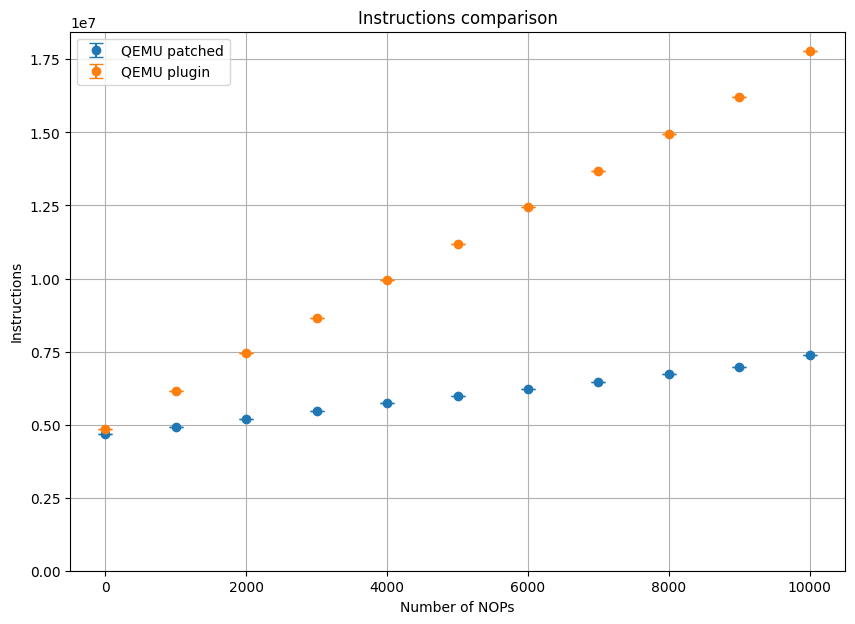

In [115]:
plot(data, patched_data)